This notebook uses StanfordCoreNLP for preprocessing and word stemming and for extracting possible keyphrases from the input documents. The results of word stemming of StanfordCoreNLP are maybe a bit different for different versions. In case of runtime error, we may have to add specific code for exception handling for that particular document.

The model also uses FastText embeddings from https://fasttext.cc/docs/en/english-vectors.html and, so download file "wiki-news-300d-1M-subword.vec.zip" and unzip it and keep it in the same folder. We tested for Glove and FastText embeddings and any file containing either of these two embeddings should work fine. Simply change the filename of the embedding in cell 4.

Datasets used are submitted along with this notebook. Unzip them and keep them in the same folder.

Ideas for implementation of PositionRank and using StanfordCoreNLP taken from https://github.com/ymym3412/position-rank

In [1]:
from stanfordcorenlp import StanfordCoreNLP
import re


class StanfordCoreNlpTokenizer(object):
    """Tokenizer for English using Stanford CoreNLP for tokenization.
    This class tokenize English sentence.
    As a default, tokenizer returns tokens whhic POS are adjective or noun.
    Simultaneously, tokenizer returns specific pattern phrases.
    """
    def __init__(self, url_or_path, port = 9000):
        """Initialize stanford core nlp tokenier.
        Args:
          url_or_path: Url string of path string of Stanford CoreNLP library.
            Provide url string if you already stand up Stanford CoreNLP server.
            If not, provide path to directory of library i.e. JavaLibraries/stanford-corenlp-full-2017-06-09/.
            When you provide path of librart, Stanford CoreNLP server will be up independent of python process.
        """
        self.tokenizer = StanfordCoreNLP(url_or_path, port = port)

    def tokenize(self, sentence, pos_filter=["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS"]):
        """Tokenize sentence.
        Tokenize sentence and return token list and phrase list.
        Phrase is continuous tokens which have specific POS pattern '(adjective)*(noun)+'
        and length are more than 3.
        You can edit filter of token POS, default are limited to adjective and noun.
        Args:
          sentence: English sentence.
          pos_filter: POS filter of token. Default are adjective and noun.
        Returns:
          Token list: Filterd by 'pos_filter' param.
          Phrase list: Specific continuous tokens.
        """
        tokens = self.tokenizer.pos_tag(sentence)
        pos_tags = [self._anonymize_pos(token[1]) for token in tokens]
        pattern = r"J*N+"
        iterator = re.finditer(pattern, "".join(pos_tags))
        phrases = filter(lambda x: len(x) <= 3, [[token[0] for token in tokens[match.start():match.end()]] for match in iterator])
        phrases = ["_".join(phrase) for phrase in phrases]
        return [token[0] for token in tokens if token[1] in pos_filter], phrases

    def _anonymize_pos(self, pos):
        """Anonymize POS tags.
        Adjective tags are replaced to 'J', noun are to 'N', and others are to 'O'.
        """
        if (pos == "JJ") or (pos == "JJR") or (pos == "JJS"):
            return "J"
        elif (pos == "NN") or (pos == "NNS") or (pos == "NNP") or (pos == "NNPS"):
            return "N"
        else:
            return "O"




StanfordCoreNLP uses a port on the system. Change port number if 9000 not free for use.

In [2]:
tokenizer = StanfordCoreNlpTokenizer("stanford-corenlp", port = 9000)

In [3]:
import math
import stemming.porter2 as porter
import numpy as np
import copy
from collections import Counter
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
import re

Change filename if different embeddings are to be used

In [4]:
def glove_embedding(filename):
    file_glove=open(filename)
    glove={}
    for line in file_glove:
        tmp=line.split()
        word=tmp[0]
        coefficient=np.asarray(tmp[1:], dtype='float')
        glove[word]=coefficient

    file_glove.close()
    return glove


#Change filename if different embeddings are to be used
fasttext=glove_embedding('wiki-news-300d-1M-subword.vec')
print(len(fasttext))

999995


Theme weighted PageRank implementation using formulae from Key2vec paper

In [14]:
def key2vec(embed_dim,embeddings,theme, sentence, tokenizer, alpha=0.85, window_size=6, num_keyphrase=10, lang="en"):
    if lang == "en":
        stem = porter.stem
    else:
        stem = lambda word: word
    
    #tokenizing using StanforCoreNLP
    original_words, phrases = tokenizer.tokenize(sentence)
    or_theme, ph_theme=tokenizer.tokenize(theme)
    ph_theme_new=[s.replace('_',' ') for s in ph_theme]
    phrases_new=[s.replace('_',' ') for s in phrases]
    original_words_new=[s.replace('_',' ') for s in original_words]
    
    
    candidate_embeddings={stem(w):[] for w in phrases_new}
    
    #embeddings for candidate keyphrases
    for phr in phrases_new:
        tmp=phr.split(" ")
        embed_value=np.zeros(embed_dim)
        for word in tmp:
            try:
                embed_value=np.add(embed_value,embeddings[word])
            except:
                embed_value=np.add(embed_value,[np.random.uniform(1e-5,0.1) for i in range(embed_dim)])
        candidate_embeddings[stem(phr)]=embed_value

    
    ph_embed_dict={w: [] for w in ph_theme_new}
    
    
    #generating theme vector
    ph_theme_embeddings=[]
    for phr in ph_theme_new:
        tmp=phr.split(" ")
        embed_value=np.zeros(embed_dim)
        for word in tmp:
            try:
                embed_value=np.add(embed_value,embeddings[word])
            except:
                embed_value=np.add(embed_value,[np.random.uniform(1e-5,0.1) for i in range(embed_dim)])
        
        ph_embed_dict[phr].append(embed_value)
    
    #averaging frequent key2vec candidate keyphrases
    keys_stem={stem(w):[] for w in ph_theme_new}
    
    for w in ph_theme_new:
        keys_stem[stem(w)].append(w)
    keys_embed={stem(w): [] for w in ph_theme_new}
    keys_cnt={stem(w):0 for w in ph_theme_new}
    for n in ph_theme_new:
        keys_cnt[stem(n)]=keys_cnt[stem(n)]+1
    for key in keys_cnt:
        if keys_cnt[key]>1:
            tmp=keys_stem[key]
            avg=np.zeros(embed_dim)
            for w in tmp:
                avg=np.add(ph_embed_dict[w][0],avg)
            keys_embed[key]=np.divide(avg,len(tmp))
        elif keys_cnt[key]==1:
            keys_embed[key]=ph_embed_dict[keys_stem[key][0]][0]

    
    theme_vector=np.zeros(embed_dim)
    for key in keys_embed.keys():
        theme_vector=np.add(keys_embed[key], theme_vector)
    
    
    
    #thematic weights: candidate similarity with theme vector
    thematic_weights={w: 0 for w in candidate_embeddings.keys()}
    weights=[]
    sum_weights=0
    for candidate in candidate_embeddings.keys():
        sim=1-spatial.distance.cosine(theme_vector, candidate_embeddings[candidate])
        thematic_weights[candidate]=sim
        weights.append(sim)
        sum_weights+=sim

    for key in thematic_weights.keys():
        thematic_weights[key]=thematic_weights[key]/sum_weights 
        
    theme_co_dict = {w: [] for w in phrases_new}
    for phrase in theme_co_dict.keys():
        idx=[m.start() for m in re.finditer(phrase, sentence)]

        for i in idx:
            lcnt=0
            rcnt=len(phrase)-1
            cnt=0
            for lcnt in range(i,-1,-1):
                if sentence[lcnt]==" ":
                    cnt+=1
                if cnt==window_size+1:
                    break
            lower=sentence[lcnt:i]
            cnt=0
            for rcnt in range(i+len(phrase),len(sentence)-1):
                if sentence[rcnt]==" ":
                    cnt+=1
                if cnt==window_size+1:
                    break
            upper=sentence[i+len(phrase):rcnt]
            for p in theme_co_dict.keys():
                if p in lower:
                    theme_co_dict[phrase].append(p)
                if p in upper:
                    theme_co_dict[phrase].append(p)
            
    
    for phrase in theme_co_dict.keys():
        temp=theme_co_dict[phrase]
        for conn in temp:
            if phrase not in theme_co_dict[conn]:
                theme_co_dict[conn].append(phrase)
    

    
    key2idx={stem(w): [] for w in theme_co_dict.keys()}
    for key in theme_co_dict.keys():
        if len(theme_co_dict[key])>0:
            for phr in theme_co_dict[key]:
                key2idx[stem(key)].append(stem(phr))
                
    key_occ={stem(w):[] for w in theme_co_dict.keys()}
    for key in theme_co_dict.keys():
        tmp=theme_co_dict[key]
        for w in tmp:
            key_occ[stem(key)].append(stem(w))
    
    for key in key2idx.keys():
        words=key2idx[key]
        tmp=[]
        for w in words:
            if w not in tmp:
                tmp.append(w)
        key2idx[key]=tmp
    

    words=[w for w in sentence.split(" ")]
    n_words=len(words)
    
    unstem={stem(w): "" for w in theme_co_dict.keys()}
    for w in theme_co_dict.keys():
        unstem[stem(w)]=w

    n_keys=len(key2idx.keys())
    key_score={w : 1.0/n_keys for w in key2idx.keys()}
    out_degree={w: len(key2idx[w]) for w in key2idx.keys()}

    
    #following code contains formulae generating the graph
    scores=[]
    pairs=[]
    sum_scores=0
    lsentence=sentence.lower()
    for key in key2idx.keys():
        k=key2idx[key]
        k_occ=key_occ[key]
        score=0.0
        for word in k:
            if word!=key:
                semantic=1-spatial.distance.cosine(candidate_embeddings[key], candidate_embeddings[word])
                try:
                    pmi=np.log(k_occ.count(word)/(lsentence.count(unstem[key].lower())*lsentence.count(unstem[word].lower())))
                except:
                    pmi=np.random.uniform(0,0.01)
                score+=(semantic*pmi/out_degree[word])
                
                
        key_score[key]=(1-alpha)*thematic_weights[key]+alpha*score


        sum_scores+=key_score[key]
    
    #scaling the scores
    for key in key_score.keys():
        key_score[key]/=sum_scores
        scores.append(key_score[key])
        pairs.append(key)
    mini=np.min(scores)
    maxi=np.max(scores)
    for key in key_score.keys():
        key_score[key]=(key_score[key]-mini)/(maxi-mini)
    scores,pairs=zip(*sorted(zip(scores, pairs)))

    key2vec=[]
    

    for i in range(len(pairs)-1,len(pairs)-num_keyphrase-1,-1):
        key2vec.append(unstem[pairs[i]].lower())
    
    #print("phrases_new="+str(len(phrases_new)))
    #print("theme_co_dict="+str(len(theme_co_dict.keys())))
    #print("key2idx="+str(len(key2idx.keys())))
    #print("key_score="+str(len(key_score.keys())))
    #dup={stem(w):0 for w in phrases_new}
    #print("stemming phrases_new="+str(len(dup.keys())))
    
    
    return key2vec,key_score,unstem
            

        
        
        
    

PositionRank implementation

In [15]:
def position_rank1(embed_dim,embeddings,theme, sentence, tokenizer, alpha=0.85, window_size=6, num_keyphrase=10, lang="en"):

    if lang == "en":
        stem = porter.stem
    else:
        stem = lambda word: word
        
    # origial words and phrase list
    original_words, phrases = tokenizer.tokenize(sentence)
    phrases_new=[s.replace('_',' ') for s in phrases]
    original_words_new=[s.replace('_',' ') for s in original_words]
    
    # stemmed words
    stemmed_word = [stem(word) for word in original_words]
    unique_word_list = set([word for word in stemmed_word])
    n = len(unique_word_list)
    
    adjancency_matrix = np.zeros((n, n))
    word2idx = {w: i for i, w in enumerate(unique_word_list)}
    p_vec = np.zeros(n)
    
    # store co-occurence words
    co_occ_dict = {w: [] for w in unique_word_list}

    # 1. initialize  probability vector
    for i, w in enumerate(stemmed_word):
        # add position score
        p_vec[word2idx[w]] += float(1 / (i+1))
        for window_idx in range(1, int(math.ceil(window_size / 2)+1)):
            if i - window_idx >= 0:
                co_list = co_occ_dict[w]
                co_list.append(stemmed_word[i - window_idx])
                co_occ_dict[w] = co_list

            if i + window_idx < len(stemmed_word):
                co_list = co_occ_dict[w]
                co_list.append(stemmed_word[i + window_idx])
                co_occ_dict[w] = co_list

    # 2. create adjancency matrix from co-occurence word
    for w, co_list in co_occ_dict.items():
        cnt = Counter(co_list)
        for co_word, freq in cnt.most_common():
            adjancency_matrix[word2idx[w]][word2idx[co_word]] = freq

    adjancency_matrix = adjancency_matrix / adjancency_matrix.sum(axis=0)
    p_vec = p_vec / p_vec.sum()
    # principal eigenvector s
    s_vec = np.ones(n) / n

    # threshold
    lambda_val = 1.0
    loop = 0
    # compute final principal eigenvector
    while lambda_val > 0.001:
        next_s_vec = copy.deepcopy(s_vec)
        for i, (p, s) in enumerate(zip(p_vec, s_vec)):
            next_s = (1 - alpha) * p + alpha * (weight_total(adjancency_matrix, i, s_vec))
            next_s_vec[i] = next_s
        lambda_val = np.linalg.norm(next_s_vec - s_vec)
        s_vec = next_s_vec
        loop += 1
        if loop > 100:
            break

    # score original words and phrases
    #word_with_score_list = [(word, s_vec[word2idx[stem(word)]]) for word in original_words]
    word_with_score_list=[]
    #print("creation words_with_score_list="+str(len(word_with_score_list)))
    #print(phrases)
    scores=[]
    for phrase in phrases:
        total_score = sum([s_vec[word2idx[stem(word)]] for word in phrase.split("_")])
        word_with_score_list.append((phrase, total_score))
        scores.append(total_score)
    
    pos_score={stem(w):0 for w in phrases_new}

    sums=0
    #for word in original_words:
    #    sums+=s_vec[word2idx[stem(word)]]
    for tup in word_with_score_list:
        tmp=stem(tup[0]).replace("_"," ")

        pos_score[tmp]=tup[1]
        sums+=tup[1]

    mini=np.min(scores)
    maxi=np.max(scores)
    for key in pos_score.keys():
        pos_score[key]=(pos_score[key]-mini)/(maxi-mini)

    sort_list = np.argsort([t[1] for t in word_with_score_list])
    keyphrase_list = []
    

    stemmed_keyphrase_list = []
    for idx in reversed(sort_list):
        keyphrase = word_with_score_list[idx][0]
        stemmed_keyphrase = " ".join([stem(word) for word in keyphrase.split("_")])
        if not stemmed_keyphrase in stemmed_keyphrase_list:
            keyphrase_list.append(keyphrase)
            stemmed_keyphrase_list.append(stemmed_keyphrase)
        if len(keyphrase_list) >= num_keyphrase:
            break
    
    #print("original_words="+str(len(original_words)))
    #print("pos_score="+str(len(pos_score.keys())))
    #print("word_with_score_list="+str(len(word_with_score_list)))
    #print("phrases="+str(len(phrases)))
    #dup={stem(w):0 for w in phrases_new}
    #print("stemming phrases_new="+str(len(dup.keys())))
    return keyphrase_list,pos_score


def weight_total(matrix, idx, s_vec):
    return sum([(wij / matrix.sum(axis=0)[j]) * s_vec[j] for j, wij in enumerate(matrix[idx]) if not wij == 0])

Evaluation code

Multiple same keyphrases may be printed, as the 3 models are being evaluated simultaneously and multiple models may find the same keyphrase.

Change value of topn variable for getting results of other values of k (top-k). Too big a value (like 15) may get runtime error as there may not be enough keywords in the ground truth of the document to compare.

Change theme variable by adding theme_pos indexes to increase the theme excerpt. Increasing theme excerpt does not effect the performance much.

Change variable dataset to "www" to get results for WWW dataset. Change pathnames accordingly if dataset stored in any other location.

In [16]:
def evaluate(ranked, label, found, total):
    for x in label:
        if x in ranked:
            print("Found:"+x)
            found += 1
    total += len(label)
    return found,total

import os
dataset="kdd"

kdd_list = os.listdir(dataset+'/contentsubset/')
data_dir = dataset+"/contentsubset/"
label_dir=dataset+"/gold/"
found = 0
total = 0
input1 = 0
topn = 8
cnt=0
found1=0
total1=0
found2=0
total2=0
for file in kdd_list:
    #print(input)
    f = open(data_dir+file, 'r')
    test = f.read()
    f.close()
    cnt+=1
    if len(test)>250:
        input1 += 1
        f = open(label_dir+file, 'r')
        label = f.read().strip().lower().split('\n')
        f.close()
        theme_pos=test.split(".")
        theme=theme_pos[0]+"."#+theme_pos[1]+"."

        key2,key_score,unstem=key2vec(300,fasttext,theme, test, tokenizer, 0.85, 5, topn)
        pos_rank,pos_score=position_rank1(300,fasttext,theme, test, tokenizer, 0.85, 5, topn)

        sum_scores=0
        new_score={w:0 for w in key_score.keys()}
        for key in key_score.keys():
            sum_scores+=key_score[key]+pos_score[key]
            new_score[key]=key_score[key]+pos_score[key]
        scores,phrases=[],[]
        for key in new_score.keys():
            new_score[key]/=sum_scores
            scores.append(new_score[key])
            phrases.append(key)
        
        scores,phrases=zip(*sorted(zip(scores, phrases)))
        ranked=[]
        #print(phrases)
        for i in range(len(phrases)-1,len(phrases)-topn-1,-1):     
            ranked.append(phrases[i].lower())
            
        label=[porter.stem(w.lower()) for w in label]
        key2=[porter.stem(w.lower()) for w in key2]
        pos_rank=[porter.stem(w.lower().replace('_',' ')) for w in pos_rank]

        found,total=evaluate(pos_rank,label,found,total)

        found1,total1=evaluate(ranked,label,found1,total1)

        found2, total2=evaluate(key2, label, found2, total2)
        

        
try:
    precise = float(found) / input1 / topn
    recall = float(found) / total
    f1 = 2 / (1.0 / recall + 1.0 / precise)
    precise1=float(found1) / input1 / topn
    recall1 = float(found1) / total1
    f2 = 2 / (1.0 / recall1 + 1.0 / precise1)
    precise2=float(found2) / input1 / topn
    recall2 = float(found2) / total2
    f3 = 2 / (1.0 / recall2 + 1.0 / precise2)
except:
    None
print("---------------")
print("No of files="+str(input1))
print("---------------")
print("PositionRank")
print(precise*100)
print(recall*100)
print(f1*100)
print("---------------")
print("Combined")
print(precise1*100)
print(recall1*100)
print(f2*100)
print("---------------")
print("Key2vec")
print(precise2*100)
print(recall2*100)
print(f3*100)

Found:disease map
Found:disease map
Found:disease map
Found:active explor
Found:clickthrough data
Found:active explor
Found:clickthrough data
Found:active explor
Found:clickthrough data
Found:quicklink
Found:data cent
Found:data cent
Found:data cent
Found:social network
Found:social network
Found:classif
Found:classif
Found:co-clust
Found:out-of-domain
Found:incremental crawl
Found:web forum
Found:incremental crawl
Found:web forum
Found:incremental crawl
Found:sitemap
Found:document represent
Found:document represent
Found:wikipedia
Found:document represent
Found:wikipedia
Found:metric learn
Found:multi-task learn
Found:transfer learn
Found:learn
Found:metric learn
Found:transfer learn
Found:learn
Found:metric learn
Found:transfer learn
Found:logistic regress
Found:naive bay
Found:logistic regress
Found:naive bay
Found:logistic regress
Found:naive bay
Found:link predict
Found:probabilistic graph
Found:social network
Found:link predict
Found:probabilistic graph
Found:social network
Foun

Found:probabilistic databas
Found:probabilistic databas
Found:probabilistic databas
Found:time seri
Found:time seri
Found:time seri
Found:sensor network
Found:sensor network
Found:sensor network
Found:model
Found:model
Found:model
Found:causal infer
Found:causal infer
Found:multi-dimensional sc
Found:multi-dimensional sc
Found:social influ
Found:social network
Found:social influ
Found:social network
Found:online commun
Found:social influ
Found:social network
Found:markov network
Found:network reconstruct
Found:network reconstruct
Found:malwar
Found:malwar
Found:malwar
Found:pe fil
Found:feature select
Found:text classif
Found:feature select
Found:text classif
Found:feature select
Found:text classif
Found:spectral clust
Found:spectral clust
Found:spectral clust
Found:controlled experi
Found:controlled experi
Found:controlled experi
Found:inferior exampl
Found:prefer
Found:inferior exampl
Found:prefer
Found:inferior exampl
Found:prefer
Found:social network
Found:social network
Found:soci

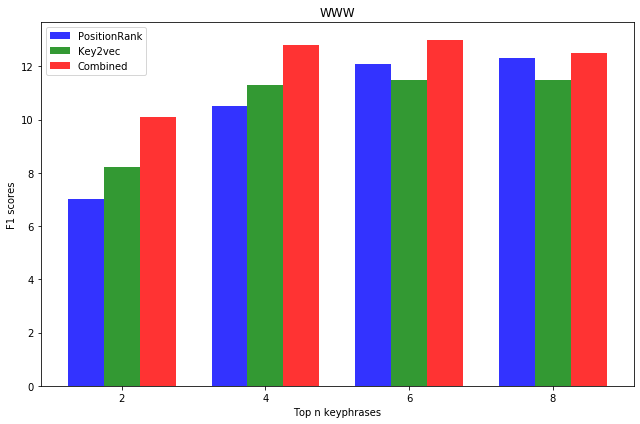

In [85]:
import matplotlib.pyplot as plt
n_groups = 4

#WWW
posrank=(7.0,10.5,12.1,12.3)
key2=(8.2,11.3,11.5,11.5)
combined=(10.1,12.8,13.0,12.5)

#KDD
posrank1 = (7.3, 10.6, 11.6, 12.1)#posrank
key21 = (8.4,12.1,13.3,12.9)#key2vec
combined1=(12.4,15.3,15.0,14.1)#combined

fig, ax = plt.subplots(figsize=(9,6))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, posrank, bar_width, 
alpha=opacity,
color='b',
label='PositionRank')

rects2 = plt.bar(index + bar_width, key2, bar_width,
alpha=opacity,
color='g',
label='Key2vec')

rects3 = plt.bar(index + 2*bar_width, combined, bar_width,
alpha=opacity,
color='r',
label='Combined')

plt.xlabel('Top n keyphrases')
plt.ylabel('F1 scores')
plt.title('WWW')
plt.xticks(index + bar_width, ('2', '4', '6', '8'))
plt.legend()

plt.tight_layout()
